# New Experiments using the Lower / upper bounds

What kind of question would we like to answer ... 

 - What is the maximum and minimum error we get from the first lower bound compared with the final latency ?

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def openLog(filename):
    toIntList = lambda x: [int(y) for y in x.strip("[]").split(",")]
    df = pd.read_csv(filename, sep=";",
                     converters={
                         "ExpansionVertex": toIntList,
                         "ExpansionEdges": toIntList,
                         "LowerBounds": toIntList,
                         "UpperBounds": toIntList,
                     }
                    )


    df.LowerBounds = df.apply(lambda x :  [y/x.AgeLatency for y in x.LowerBounds]  , axis = 1)
    df.UpperBounds = df.apply(lambda x :  [y/x.AgeLatency for y in x.UpperBounds]  , axis = 1)
    df.ExpansionVertex = df.apply(lambda x :  [y/(x.sum_n+2) for y in x.ExpansionVertex]  , axis = 1)

    assert(df.ExpansionVertex.apply(max).max())
    assert(df.LowerBounds.apply(max).max())
    assert(df.UpperBounds.apply(max).max())

    df["BoundsDistances"] = df.apply(lambda x : [abs( l - r ) for (l,r) in zip(x.LowerBounds,x.UpperBounds)], axis=1)
    return df

df = openLog("automotive.test.log")

##  What is the maximum and minimum error we get from the first lower bound compared 

with the final latency ?

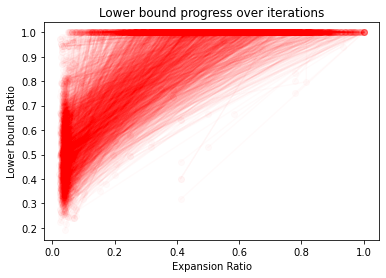

In [53]:
import matplotlib.pyplot as plt

for (x,y) in list(df.apply(lambda x :  (x.ExpansionVertex, x.LowerBounds)  , axis = 1)) :
    plt.plot(x,y, marker="o", color = "r", alpha = 0.02)
_ = plt.xlabel("Expansion Ratio")
_ = plt.ylabel("Lower bound Ratio")
_ = plt.title("Lower bound progress over iterations")

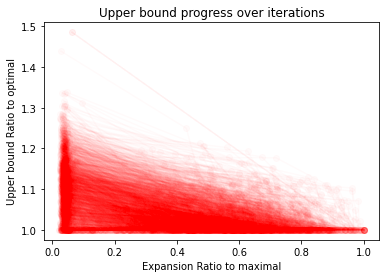

In [54]:
for (x,y) in list(df.apply(lambda x :  (x.ExpansionVertex, x.UpperBounds)  , axis = 1)) :
    plt.plot(x,y, marker="o", color = "r", alpha = 0.02)
_ = plt.xlabel("Expansion Ratio to maximal")
_ = plt.ylabel("Upper bound Ratio to optimal")
_ = plt.title("Upper bound progress over iterations")

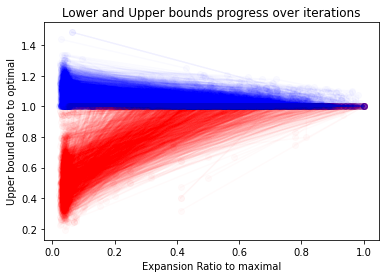

In [80]:
def lower_upper_detailled (df, alpha = None) :
    if not alpha :
        alpha = max ( 0.02,  1.0 / len(df) )
    for (x,y) in list(df.apply(lambda x :  (x.ExpansionVertex, x.LowerBounds)  , axis = 1)) :
        plt.plot(x,y, marker="o", color = "r", alpha = alpha)
    for (x,y) in list(df.apply(lambda x :  (x.ExpansionVertex, x.UpperBounds)  , axis = 1)) :
        plt.plot(x,y, marker="o", color = "b", alpha = alpha)
    _ = plt.xlabel("Expansion Ratio to maximal")
    _ = plt.ylabel("Upper bound Ratio to optimal")
    _ = plt.title("Lower and Upper bounds progress over iterations")
lower_upper_detailled (df)

In [56]:
print(df.columns)
print(df.IterationCount.max())

Index(['kind', 'n', 'm', 'sum_n', 'AgeLatency', 'IterationCount',
       'ExpansionVertex', 'ExpansionEdges', 'LowerBounds', 'UpperBounds',
       'gen_time', 'sp_time', 'BoundsDistances'],
      dtype='object')
12


## Shallow study of the data

In [57]:
['kind', 'n', 'm', 'sum_n', 'AgeLatency', 'IterationCount',
       'ExpansionVertex', 'ExpansionEdges', 'LowerBounds', 'UpperBounds',
       'gen_time', 'sp_time', 'BoundsDistances']

['kind',
 'n',
 'm',
 'sum_n',
 'AgeLatency',
 'IterationCount',
 'ExpansionVertex',
 'ExpansionEdges',
 'LowerBounds',
 'UpperBounds',
 'gen_time',
 'sp_time',
 'BoundsDistances']

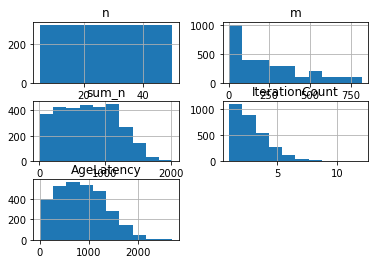

In [58]:
_ = df[[ "n","m",  "sum_n", "IterationCount","AgeLatency"]].hist()
## sum_n is the complexity as the sum of Ni 

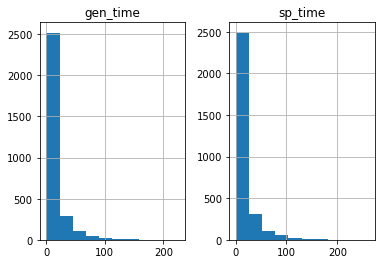

In [59]:
_ = df[["gen_time", "sp_time"]].hist()

/home/toky/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


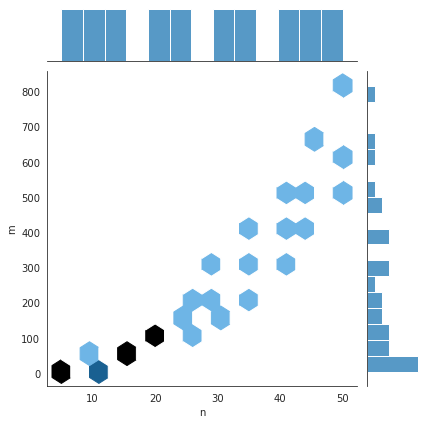

In [60]:
import seaborn as sns

with sns.axes_style('white'):
    sns.jointplot("n", "m", data=df, kind='hex')



## a bit more depth

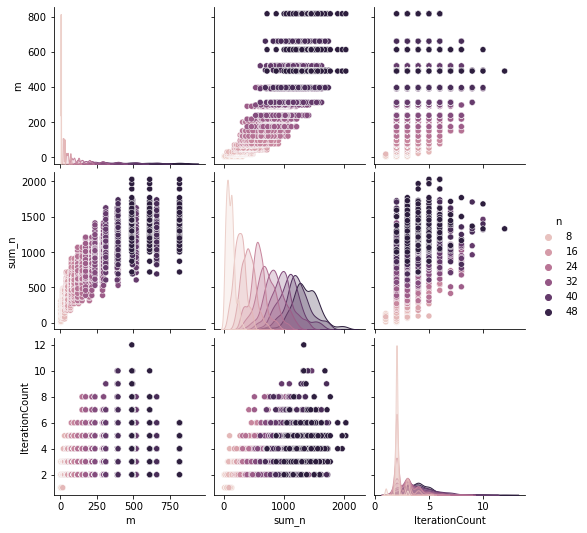

In [61]:
_ = sns.pairplot(data=df[[ "n","m",  "sum_n", "IterationCount"]], hue="n")

## Study of the bounds

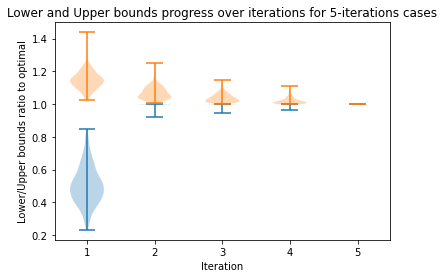

In [62]:
def plotBoundsByIteration(df, itercount) :
    sdf  =  df[df.IterationCount == itercount]
    _ = plt.violinplot(pd.DataFrame(sdf.LowerBounds.to_list(), columns=range(itercount)))
    _ = plt.violinplot(pd.DataFrame(sdf.UpperBounds.to_list(), columns=range(itercount)))
    _ = plt.xlabel("Iteration")
    _ = plt.ylabel("Lower/Upper bounds ratio to optimal")
    
plotBoundsByIteration(df, 5)
_ = plt.title("Lower and Upper bounds progress over iterations for 5-iterations cases")

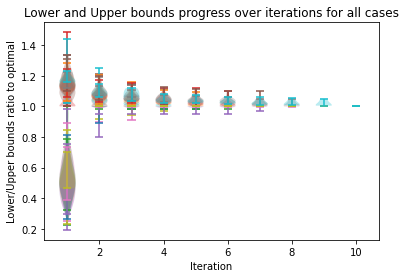

In [63]:
for it in range(1,df.IterationCount.max() + 1) :
    if len(df[df.IterationCount == it]) > 1:
        plotBoundsByIteration(df, it)
_ = plt.title("Lower and Upper bounds progress over iterations for all cases")

In [66]:
def plotBounds(df) :
    sdf = df.copy()
    sdf.LowerBounds = sdf.apply (lambda x : x.LowerBounds + (df.IterationCount.max() - x.IterationCount)*x.LowerBounds[-1:], axis = 1)
    sdf.UpperBounds = sdf.apply (lambda x : x.UpperBounds + (df.IterationCount.max() - x.IterationCount)*x.UpperBounds[-1:], axis = 1)
    _ = plt.violinplot(pd.DataFrame(sdf.LowerBounds.to_list(), columns=range(df.IterationCount.max())))
    _ = plt.violinplot(pd.DataFrame(sdf.UpperBounds.to_list(), columns=range(df.IterationCount.max())))
    _ = plt.xlabel("Iteration")
    _ = plt.ylabel("Lower/Upper bounds ratio to optimal")
    _ = plt.title("Lower and Upper bounds progress over iterations for all cases")

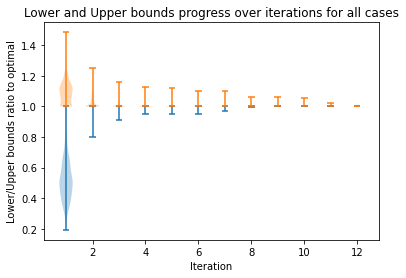

In [67]:
plotBounds(df) 

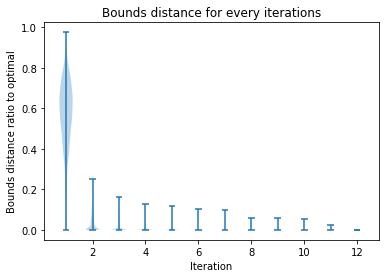

In [68]:
def plotBoundsDistances(df) :
    sdf = df.copy()
    sdf.BoundsDistances = sdf.apply (lambda x : x.BoundsDistances + (sdf.IterationCount.max() - x.IterationCount)*x.BoundsDistances[-1:], axis = 1)
    _ = plt.violinplot(pd.DataFrame(sdf.BoundsDistances.to_list(), columns=range(sdf.IterationCount.max())))
    _ = plt.title("Bounds distance for every iterations")
    _ = plt.xlabel("Iteration")
    _ = plt.ylabel("Bounds distance ratio to optimal")
plotBoundsDistances(df)

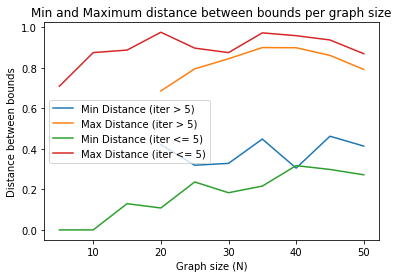

In [49]:
def plotMinMaxBoundDistance (df, label1 = "Minimal distance", label2 = "Maximal distance") :
    sdf = df.copy()
    sdf.BoundsDistances = sdf.apply (lambda x : x.BoundsDistances + (sdf.IterationCount.max() - x.IterationCount)*x.BoundsDistances[-1:], axis = 1)
    sdf["BoundsDistancesMax"] = sdf.BoundsDistances.apply(lambda x : max(x))

    x = sdf.groupby("n").max().reset_index()["n"]
    y1 = sdf.groupby("n").min().reset_index()["BoundsDistancesMax"]
    y2 = sdf.groupby("n").max().reset_index()["BoundsDistancesMax"]

    _ = plt.plot(x,y1,  label = label1)
    _ = plt.plot(x,y2,  label = label2)
    _ = plt.title("Min and Maximum distance between bounds per graph size")
    _ = plt.xlabel("Graph size (N)")
    _ = plt.ylabel("Distance between bounds")
    _ = plt.legend()
plotMinMaxBoundDistance(df[df.IterationCount > 5], label1="Min Distance (iter > 5)", label2="Max Distance (iter > 5)")
plotMinMaxBoundDistance(df[df.IterationCount <= 5], label1="Min Distance (iter <= 5)", label2="Max Distance (iter <= 5)")

In [50]:
## Reuse the plot on another file
df2 = openLog("automotive.bigtest.log")

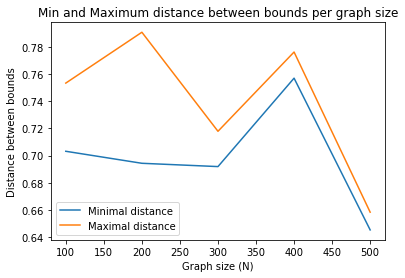

In [51]:
plotMinMaxBoundDistance(df2)

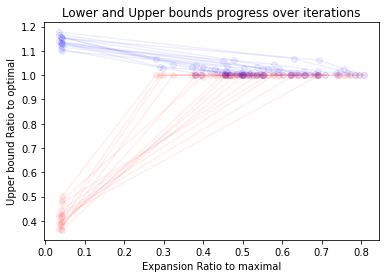

In [81]:
lower_upper_detailled (df2)

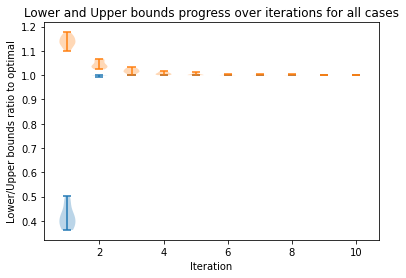

In [69]:
plotBounds(df2)

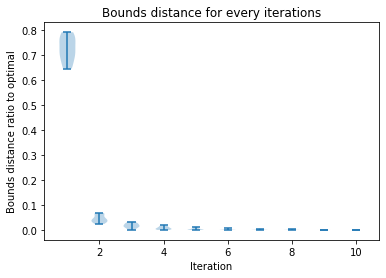

In [70]:
 plotBoundsDistances(df2)